In [229]:
from langchain import document_loaders as dl
from langchain_core.documents.base import Document
from langchain import embeddings
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain import text_splitter as ts
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool
import torch
import faiss
from typing import Annotated, Sequence, Literal, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
import os
from langchain import hub
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, create_react_agent
import json
import numexpr
import pprint
import math
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [230]:
dir_path = 'C:/Users/Carlini/OneDrive - Alma Mater Studiorum Università di Bologna/Articoli/MS'

loader = dl.DirectoryLoader(dir_path, glob='*.pdf', loader_cls=dl.PyPDFLoader, show_progress=True)
doc = loader.load()

text_splitter = ts.RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(doc)

100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


In [231]:
doc

[Document(metadata={'source': 'C:\\Users\\Carlini\\OneDrive - Alma Mater Studiorum Università di Bologna\\Articoli\\MS\\1-s2.0-S1474442222004264-main.pdf', 'page': 0}, page_content='350 www.thelancet.com/neurology   Vol 22   April 2023\nReview\nLancet Neurol 2022; 22: 350–66\nSee Comment page 288\n*Contributed equally\nDivision of Neurology, \nDepartment of Medicine, \nSt Michael’s Hospital, \nUniversity of Toronto, Toronto, \nON, Canada (K M Krysko MD); \nLi Ka Shing Knowledge \nInstitute, Toronto, ON, Canada \n(K M Krysko); Preventive \nNeurology Unit, Wolfson \nInstitute of Population Health, \nQueen Mary University \nLondon, London, UK \n(R Dobson FRCP); Department \nof Neurology, Royal London \nHospital, Barts Health NHS \nTrust, London, UK (R Dobson); \nDepartment of Medicine, \nDivision of Neurology, Amiri \nHospital, Sharq, Kuwait \n(R Alroughani MD); Department \nNEUROFARBA, Section of \nNeurosciences, University of \nFlorence, Florence, Italy \n(Prof M P Amato MD); IRCCS \nFo

In [232]:
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("Hello world!")))

vector_store = FAISS(embedding_function=embeddings, index=index, docstore=InMemoryDocstore(), index_to_docstore_id={})

# _ = vector_store.add_documents(all_splits)


In [233]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    context: List[Document]
    user_question: str

In [234]:
rtv = vector_store.as_retriever(search_kwargs={"k": 5})
@tool
def retriever(query: str):
    """Retrieve information related to a query.
    
    Args:
        query: The query to search for.

    """
    retrieved_docs = rtv.invoke(query)

    return retrieved_docs

@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**5" for "37593^5"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )

tools = [retriever, calculator]

In [240]:
def call_tools(msg):
    tool_map = {tool.name: tool for tool in tools}

    tool_calls = msg.tool_calls.copy()

    for tool_call in tool_calls:
        tool_call["output"] = tool_map[tool_call["name"]].invoke(tool_call["args"])

    return tool_calls

def agent(state):

    print("---AGENT INVOKED---")

    model = ChatOllama(model="llama3-groq-tool-use:8b-fp16", temperature=0)
    model_with_tools = model.bind_tools(tools)

    user_question = state["messages"][-1].content

    out = model_with_tools.invoke(user_question)

    out.tool_calls = call_tools(out)

    return {"messages": [out], "user_question": user_question}

def router(state):
    print("---ROUTER INVOKED---")

    message = state["messages"][-1]

    if message.tool_calls:
        name = message.tool_calls[0]["name"]

        if name == "retriever":
            return f'{name}_node'
        else:
            return END
    else:
        return END
    
def retriever_node(state):
    print("---RETRIEVE NODE INVOKED---")
    
    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    user_question = state["user_question"]
    context = state["messages"][-1].tool_calls[0]["output"]

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    formatted_docs = format_docs(context)

    prompt = PromptTemplate(
        template="""You are an helpful assistant that can provide information to the user
        based on the retrieved documents. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        Provide a concise answer to the question using no more than 3 sentences. \n
        If context is empty, ask the user to provide some documents. \n""",
        input_variables=["context", "question"],
    )

    chain = prompt | model

    out = chain.invoke({"context": formatted_docs, "question": user_question})

    return {"messages": [out], "user_question": user_question, "context": context}
    

In [241]:
memory = MemorySaver()

workflow = StateGraph(AgentState)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("agent", agent)
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", router)
workflow.add_edge("retriever_node", END)

graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

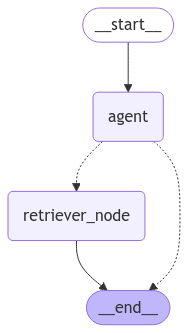

In [242]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [243]:
inputs = {
    "messages": [
        HumanMessage(content="What's 0.5 to the power of 3?"),
    ]
}

for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---ROUTER INVOKED---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-11T12:29:12.2185778Z', 'done': True, 'done_reason': 'stop', 'total_duration': 814875500, 'load_duration': 15434900, 'prompt_eval_count': 264, 'prompt_eval_duration': 14000000, 'eval_count': 29, 'eval_duration': 785000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='calculator', arguments={'expression': '0.5**3'}))])}, id='run-66da7e1a-6451-4102-85d9-b6ea51c652c2-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '0.5**3'}, 'id': '50fd1061-ef1b-4355-8bb0-368ce2bd657e', 'type': 'tool_call', 'output': '0.125'}], usage_metadata={'input_tokens': 264, 'output_tokens': 29, 'total_tokens': 293})],
  'user_question': "What's 0.5 to the power of 3?"}
'\n---\n'


In [244]:
inputs = {
    "messages": [
        HumanMessage(content="Is relapsing-remitting multiple sclerosis mentioned in the documents?"),
    ]
}

for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---ROUTER INVOKED---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-11T12:29:14.5395975Z', 'done': True, 'done_reason': 'stop', 'total_duration': 904531000, 'load_duration': 14675700, 'prompt_eval_count': 265, 'prompt_eval_duration': 13000000, 'eval_count': 34, 'eval_duration': 875000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='retriever', arguments={'query': 'relapsing-remitting multiple sclerosis'}))])}, id='run-e47d7b65-524d-4e82-a838-df32df800dd5-0', tool_calls=[{'name': 'retriever', 'args': {'query': 'relapsing-remitting multiple sclerosis'}, 'id': 'af0ad455-8aeb-4db0-ac1b-be54093221e7', 'type': 'tool_call', 'output': []}], usage_metadata={'input_tokens': 265, 'output_tokens': 34, 'total_tokens': 299})],
  'user_question': 'Is relapsing-remitting multiple sclerosis me

In [34]:
model = ChatOllama(model="llama3-groq-tool-use:8b-fp16", temperature=0)

model_with_tools = model.bind_tools(tools)

out = model_with_tools.invoke([HumanMessage(content="Retrieve information about multiple sclerosis treatments from the documents I gave you.")])

In [35]:
out

AIMessage(content="I'm sorry, but I don't have the capability to store or access external documents. However, if you provide me with a specific query related to multiple sclerosis treatments, I can help retrieve relevant information for you.", additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-11T08:59:15.0030497Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1414993400, 'load_duration': 15253100, 'prompt_eval_count': 265, 'prompt_eval_duration': 4000000, 'eval_count': 44, 'eval_duration': 1394000000, 'message': Message(role='assistant', content="I'm sorry, but I don't have the capability to store or access external documents. However, if you provide me with a specific query related to multiple sclerosis treatments, I can help retrieve relevant information for you.", images=None, tool_calls=None)}, id='run-5c0919ea-dcf6-4c37-94ef-529a8a0e5ebf-0', usage_metadata={'input_tokens': 265, 'output_tokens': 44, 'total_tokens': 30

In [215]:
inputs = {
    "messages": [
        HumanMessage(content="Is relapsing-remitting multiple sclerosis mentioned in the documents?"),
    ]
}

out = graph.invoke(inputs, config=config)

---AGENT INVOKED---
---ROUTER INVOKED---
---RETRIEVE NODE INVOKED---


In [245]:
out

{'messages': [HumanMessage(content='Is relapsing-remitting multiple sclerosis mentioned in the documents?', additional_kwargs={}, response_metadata={}, id='8e498160-d490-4202-bb47-f9a44d55e656'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-11T11:23:24.955168Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1247756900, 'load_duration': 14651800, 'prompt_eval_count': 265, 'prompt_eval_duration': 297000000, 'eval_count': 34, 'eval_duration': 934000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='retriever', arguments={'query': 'relapsing-remitting multiple sclerosis'}))])}, id='run-ebcab620-d142-44dd-bb91-cda042b72a34-0', tool_calls=[{'name': 'retriever', 'args': {'query': 'relapsing-remitting multiple sclerosis'}, 'id': 'c47f0c68-b8eb-4af4-a0d3-c5290a6215d0', 'type': 'tool_call', 'output': [Document(metadata={'source': 'C:\\Users\\Ca

In [224]:
references = {}

for doc in out['context']:
    title = os.path.basename(doc.metadata.get("source", "Unknown"))
    page_number = doc.metadata.get("page", "Unknown")

    references[title] = f'page: {page_number}'

In [225]:
references

{'Annals of Neurology - 2024 - Calabrese - Determinants and Biomarkers of Progression Independent of Relapses in Multiple.pdf': 'page: 1',
 'READ_Annals of Neurology - 2024 - Calabrese - Determinants and Biomarkers of Progression Independent of Relapses in Multiple.pdf': 'page: 1',
 'How patients with multiple sclerosis acquire disability.pdf': 'page: 13',
 'Annals of Neurology - 2019 -  - Silent progression in disease activity free relapsing multiple sclerosis.pdf': 'page: 12',
 'Silent progression in disease activity–free relapsing multiple sclerosis.pdf': 'page: 12'}